# Plagiarism Detection Model (Local optimization version)

**Note to reviewer:** I have access to workstation with a beefy GPU (Geforce Ti 2080 RTX) so I prefer testing everything locally before spending some time (and money) on a Sagemaker notebook instance.

This noteboook contains all the code used to create and test the two models locally before moving them to the appropriate files. Its only goal is to speed up my completion of the project.


In [1]:
# Imports
import os
import sys
import subprocess
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 125
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Dummy environment variables to mimic AWS environment
AWS_env = {
    'SM_HOSTS': "{}",
    'SM_CURRENT_HOST': "localhost",
    'SM_MODEL_DIR': "model",
    'SM_CHANNEL_TRAIN': "plagiarism_data",
    'SM_OUTPUT_DATA_DIR': "",
    'SM_NUM_GPUS': "1"
}


# Useful function to run external script
def run_script(script_path, script_args={}):
    python_exe = sys.executable

    args = [
        python_exe,
        script_path,
    ]

    for key, val in script_args.items():
        args.extend(["--{}".format(key), str(val)])

    env = AWS_env.copy()  # Copy in case we modify it

    print("Running the following command:\n{}".format(
        " ".join(args)))

    output = subprocess.run(
       args,
       env=env,
       capture_output=True,
       text=True
       )

    if output.returncode != 0:
        raise RuntimeError(
            "Script failed!\nOutput:\n{}".format(output.stderr))
    else:
        print("Script gracefully ended.\nOutput:\n{}".format(output.stdout))

def print_model_validation(model):
    try:
        predictions = model.predict(test_x.values)
    except AttributeError:
        # Pytorch model
        predictions = np.round(model.eval()(torch.Tensor(test_x.values)).tolist()).astype(int)
    
    score = accuracy_score(test_y.values, predictions) * 100
    print("Results for {}:".format(model.__class__.__name__))
    print("- Accuracy: {:.2f}% -> {}".format(score, "PASSED" if score > 90 else "FAILED"))
    print("- Confusion matrix:")
    print(confusion_matrix(test_y.values, predictions))
    

In [3]:
# Load data

train_data = pd.read_csv("plagiarism_data/train.csv", header=None, names=None)

# Labels are in the first column
train_y = train_data.iloc[:,0]
train_x = train_data.iloc[:,1:]

test_data = pd.read_csv("plagiarism_data/train.csv", header=None, names=None)

# Labels are in the first column
test_y = train_data.iloc[:,0]
test_x = train_data.iloc[:,1:]

## Creating and testing the Naive Bayes classifier

In [4]:
%%time

clf = GaussianNB() # Base estimator
clf.fit(train_x, train_y)

print_model_validation(clf)


Results for GaussianNB:
- Accuracy: 94.29% -> PASSED
- Confusion matrix:
[[27  1]
 [ 3 39]]
CPU times: user 4.76 ms, sys: 500 µs, total: 5.26 ms
Wall time: 4.58 ms


## Creating and testing the PyTorch model

In [5]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_features, hidden_dim, output_dim):
        super(BinaryClassifier, self).__init__()
        
        self.input_layer = nn.Linear(input_features, hidden_dim)
        self.dropout = nn.Dropout(0.2)
        self.hidden_layer = nn.Linear(hidden_dim, output_dim)
        self.output_layer = nn.Linear(output_dim, 1)
        self.activation = nn.Sigmoid()
    
    def forward(self, data):
        
        a1 = self.input_layer(data)
        dout = self.dropout(a1)
        a2 = self.hidden_layer(dout)
        a3 = self.output_layer(a2)
        y = self.activation(a3.squeeze())
        
        return y


In [6]:
from source_pytorch.train import _get_train_data_loader, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BinaryClassifier(2, 32, 8).to(device)

train_loader = _get_train_data_loader(10, "plagiarism_data/")

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

losses = train(model, train_loader, 50, criterion, optimizer, device)

Get train data loader.
Epoch: 1, Loss: 0.7169046146529061
Epoch: 2, Loss: 0.6790375454085213
Epoch: 3, Loss: 0.6525273408208575
Epoch: 4, Loss: 0.6004715647016253
Epoch: 5, Loss: 0.5747519476073129
Epoch: 6, Loss: 0.546665221452713
Epoch: 7, Loss: 0.5107447334698269
Epoch: 8, Loss: 0.49570442949022564
Epoch: 9, Loss: 0.4779541237013681
Epoch: 10, Loss: 0.4553591821874891
Epoch: 11, Loss: 0.44450793521744864
Epoch: 12, Loss: 0.42405071428843905
Epoch: 13, Loss: 0.4104349230016981
Epoch: 14, Loss: 0.40060392235006603
Epoch: 15, Loss: 0.37772044113704134
Epoch: 16, Loss: 0.36760539029325756
Epoch: 17, Loss: 0.35271851292678286
Epoch: 18, Loss: 0.3392208750758852
Epoch: 19, Loss: 0.3526063178266798
Epoch: 20, Loss: 0.32492925226688385
Epoch: 21, Loss: 0.31409065212522236
Epoch: 22, Loss: 0.31860547619206564
Epoch: 23, Loss: 0.3008038082293102
Epoch: 24, Loss: 0.30107676557132174
Epoch: 25, Loss: 0.28189000274453846
Epoch: 26, Loss: 0.28286908141204287
Epoch: 27, Loss: 0.29100819464240757
E

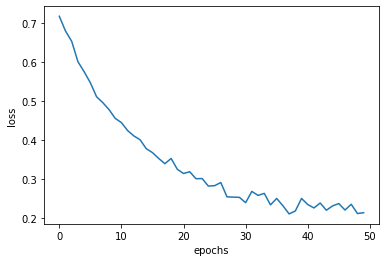

In [7]:
# Check if the number of epochs is OK
sns.lineplot(x=np.arange(len(losses)), y=losses, palette="muted")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [8]:
print_model_validation(model.to(torch.device("cpu")))

Results for BinaryClassifier:
- Accuracy: 95.71% -> PASSED
- Confusion matrix:
[[28  0]
 [ 3 39]]
